# Notebook 4 of the eLetter response to Hubbard & Bradley

In this notebook, we present a test in which we shuffle the Green's functions.

If, as suggested by Hubbard & Bradley, common modes dominate the stack, then shuffling the Green's functions before calculating the stack should not have much effect on the results. We test this idea and randomly shuffle the Green's functions associated with the different time series, earthquake by earthquake. We then stack together the stacks obtained for the different earthquakes and calculate the ratio r between the last point of the moving average and its maximum on the previous 46 h (as defined in the paper). 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime
from random import randrange, uniform, shuffle

In [2]:
nsample = 576         # Number of samples in time series
mu=29353000000        # Shear modulus
wd = 22               # Window duration for the moving average (in number of samples), 22 samples --> 1h50m
Ntest = 100000        # Number of samples in the tests

Nsma = nsample - wd   # Number of samples in the moving average time series
N0 = Nsma - 24        # Number of samples of the moving average unafected by the last 2 hours
nd = int(nsample/2)
t = np.arange(-48-1/24,0-1/24,1/12)

In [3]:
data_byEQ_dir = 'data_byEQ'  # Directory where pre-earthquake time series are stored

leq_file = glob(data_byEQ_dir+"/20*_MW_*/dot_product_stack.txt")  # Full earthquake directory list

big9 = ['20110407T14:32:43_MW_7.1','20140310T05:18:13_MW_7.0','20121207T08:18:23_MW_7.2',\
        '20110311T05:46:24_MW_9.0','20131025T17:10:19_MW_7.1','20100404T22:40:43_MW_7.1',\
        '20120905T14:42:07_MW_7.5','20110309T02:45:20_MW_7.3','20161113T11:02:56_MW_7.9']

#leq_file = [data_byEQ_dir+'/'+x+"/dot_product_stack.txt" for x in big9] # Uncomment to restrict the analysis 
                                                                         # to the 9 main earthquakes 

B = np.genfromtxt('scardec_M7_full.txt')  # Earthquake parameters

eq_lat, eq_lon, eq_date = B[:,7], B[:,8], []
for i in range(len(B)):
    eq_date.append(datetime(int(B[i,1]),int(B[i,2]),int(B[i,3]),int(B[i,4]),int(B[i,5])))

In [4]:
# Calculate the Green's functions, load and store the data

east, north = [], []
Ge, Gn, sj2 = [], [], []
k = 0

for eq_file in leq_file:
    
    eq = eq_file.split('/')[-2]
    np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=str,usecols=0))
    Nst = len(np_code)
    
    if Nst > 1:
        
        syn_east = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=0))
        syn_north = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=1))
        sigmaj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmaj2.txt',dtype=float))
        east.append(np.zeros([Nst,nsample])) 
        north.append(np.zeros([Nst,nsample]))
        Ge.append(syn_east)
        Gn.append(syn_north)
        sj2.append(sigmaj2)
        for i in range(Nst):
            ts = np.genfromtxt(data_byEQ_dir+'/'+eq+'/TS_'+np_code[i]+'.dat')
            east[k][i,:] = ts[:,7] - np.median(ts[0:nd,7]) 
            north[k][i,:] = ts[:,8] - np.median(ts[0:nd,8])
        
        k = k+1

In [5]:
# Calculate the stack before the earthquakes (excluding events recored by 1 station for fair comparaison)

real_eq_stack = np.zeros([len(Ge),nsample])
for k in range(len(Ge)):
    real_eq_stack[k,:] = np.dot(Ge[k]/sj2[k],east[k]) + np.dot(Gn[k]/sj2[k],north[k])
real_stack = sum(real_eq_stack)

In [ ]:
# Uncomment this cell to calculate the stack not excluding 1-station events

#real_eq_stack = np.zeros([len(leq_file),nsample])
#k = 0
#for eq_file in leq_file:    
#    eq = eq_file.split('/')[-2]
#    np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=str,usecols=0))
#    Nst = len(np_code)
#    syn_east = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=0))
#    syn_north = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=1))
#    sigmaj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmaj2.txt',dtype=float))
#    dp = np.zeros([Nst,nsample])
#    for i in range(Nst):
#        ts = np.genfromtxt(data_byEQ_dir+'/'+eq+'/TS_'+np_code[i]+'.dat')
#        E = ts[:,7] - np.median(ts[0:nd,7]) 
#        N = ts[:,8] - np.median(ts[0:nd,8])
#        dp[i,:] = (syn_east[i]*E + syn_north[i]*N)/sigmaj2[i]
#    real_eq_stack[k,:] = sum(dp)    
#    k = k+1
#real_stack = sum(real_eq_stack)

In [6]:
# Calculate the moving average and r 

mav_real_stack = np.zeros(Nsma)
for j in range(Nsma):
    mav_real_stack[j] = np.mean(real_stack[j:j+wd])    
r0 = mav_real_stack[-1] / max(mav_real_stack[0:N0]) 

The value of r with the right Green's functions (excluding 1-station events) is 1.79


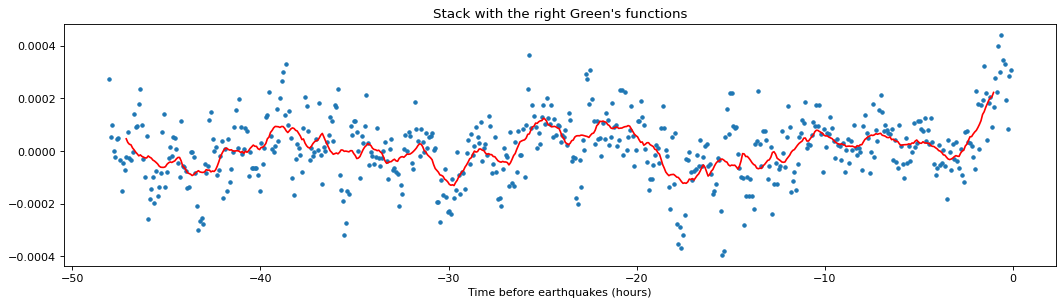

In [7]:
# Plot the global stack (excluding 1-station events)

plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,real_stack,'.')
plt.plot(t[11:-11],mav_real_stack,'r')
plt.title('Stack with the right Green\'s functions')
plt.xlabel('Time before earthquakes (hours)')
print('The value of r with the right Green\'s functions (excluding 1-station events) is '+str(round(r0,2)))

In [8]:
# Calculate stacks with shuffled Green's functions (this will take some time)

stack = np.zeros([Ntest,nsample])

for n in range(Ntest):
    eq_stack = np.zeros([len(Ge),nsample])
    for k in range(len(Ge)):
        I = np.arange(len(Ge[k]))
        shuffle(I)                # here the shuffling is made earthquake by earthquake (at each k increment)
        eq_stack[k,:] = np.dot(Ge[k][I]/sj2[k],east[k]) + np.dot(Gn[k][I]/sj2[k],north[k])
    stack[n,:] = sum(eq_stack)

In [9]:
# Calculate r with shuffled Green's functions

mav_stack = np.zeros([Ntest,Nsma])
for j in range(Nsma):
    mav_stack[:,j] = np.mean(stack[:,j:j+wd],axis=1)
r = mav_stack[:,-1] / np.max(mav_stack[:,0:N0],axis=1)  

The median of r with shuffled Green's functions is 1.23


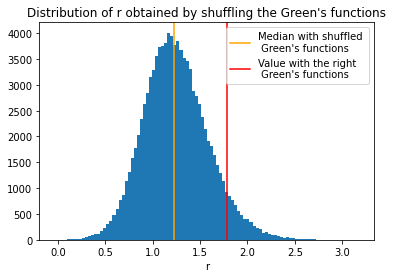

In [10]:
# Plot r with shuffled Green's functions

plt.hist(r,100)
plt.axvline(x=np.median(r),c='orange')
plt.axvline(x=r0,c='red')
plt.xlabel('r')
plt.title('Distribution of r obtained by shuffling the Green\'s functions')
plt.legend(['Median with shuffled \n Green\'s functions','Value with the right \n Green\'s functions'])
plt.savefig('r_GF_shuffled.pdf')
print('The median of r with shuffled Green\'s functions is '+str(round(np.median(r),2)))

In [11]:
p = 100*len(np.where(r>=r0)[0])/len(r)
print('r > '+str(round(r0,2))+' has a probability of '+str(round(p,1))+' %')

r > 1.79 has a probability of 6.4 %


If a common mode dominates the different earthquake stacks, then shuffling the Green's functions should not affect the stacks. We see that the median of r (orange line) obtained by shuffling the Green's functions is high (a value > 1 represents a significant statistical anamoly). This likely indicates a significant influence of common mode noise in the signal we observe. Nevertheless, the value obtained with the right Green's functions (red line) is significanly larger than this median value and lies in the tail of the Gaussian distribution. One way to read this is that a common mode alone has only a 6.5 % probaility to explain the pattern we observe and the statistics on r.

## Excluding the Tohoku earthquake

One may argue that a possible afterslip signal following the Tohoku foreshock may bias the Tohoku stack. We therefore reproduce the test above excluding the Tohoku event.  

In [12]:
# Find Tohoku index

k = 0
for eq_file in leq_file:
    eq = eq_file.split('/')[-2]
    np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=str,usecols=0))
    Nst = len(np_code)
    if Nst > 1:    
        if eq=='20110311T05:46:24_MW_9.0':
            I_TO = k
            print('The index of the Tohoku stack is '+str(I_TO))
        k = k+1

The index of the Tohoku stack is 11


In [13]:
# Remove Tohoku 

Ge_noTO = Ge[0:I_TO] + Ge[I_TO+1:len(Ge)]
Gn_noTO = Gn[0:I_TO] + Gn[I_TO+1:len(Gn)]
east_noTO = east[0:I_TO] + east[I_TO+1:len(east)]
north_noTO = north[0:I_TO] + north[I_TO+1:len(north)]
sj2_noTO = sj2[0:I_TO] + sj2[I_TO+1:len(sj2)]

In [14]:
# Re-calculate the stack with the right Green's functions without Tohoku

real_eq_stack_noTO = np.zeros([len(Ge_noTO),nsample])
for k in range(len(Ge_noTO)):
    real_eq_stack_noTO[k,:] = np.dot(Ge_noTO[k]/sj2_noTO[k],east_noTO[k]) + np.dot(Gn_noTO[k]/sj2_noTO[k],north_noTO[k])
real_stack_noTO = sum(real_eq_stack_noTO)

In [15]:
# Re-calculate the moving average and r without Tohoku

mav_real_stack_noTO = np.zeros(Nsma)
for j in range(Nsma):
    mav_real_stack_noTO[j] = np.mean(real_stack_noTO[j:j+wd])    
r0_noTO = mav_real_stack_noTO[-1] / max(mav_real_stack_noTO[0:N0])

The value of r with the right Green's functions excluding Tohoku (and excluding 1-station events) is 1.42


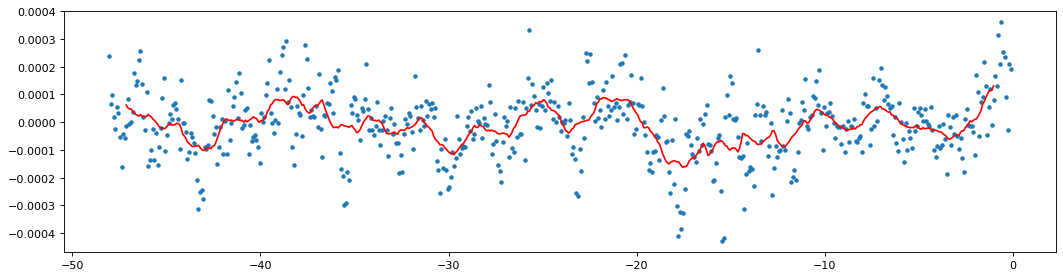

In [16]:
# Re-plot the global stack and the moving average without Tohoku

plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,real_stack_noTO,'.')
plt.plot(t[11:-11],mav_real_stack_noTO,'r')
print('The value of r with the right Green\'s functions excluding Tohoku (and excluding 1-station events) is '+str(round(r0_noTO,2)))

In [17]:
# Re-calculate the stacks with the shuffled Green's functions excluding Tohoku

stack_noTO = np.zeros([Ntest,nsample])

for n in range(Ntest):
    eq_stack = np.zeros([len(Ge_noTO),nsample])
    for k in range(len(Ge_noTO)):
        I = np.arange(len(Ge_noTO[k]))
        shuffle(I)
        eq_stack[k,:] = np.dot(Ge_noTO[k][I]/sj2_noTO[k],east_noTO[k]) + np.dot(Gn_noTO[k][I]/sj2_noTO[k],north_noTO[k])
    stack_noTO[n,:] = sum(eq_stack)

In [18]:
# Re-calculate r with the shuffled Green's functions excluding Tohoku

mav_stack_noTO = np.zeros([Ntest,Nsma])
for j in range(Nsma):
    mav_stack_noTO[:,j] = np.mean(stack_noTO[:,j:j+wd],axis=1)   
r_noTO = mav_stack_noTO[:,-1] / np.max(mav_stack_noTO[:,0:N0],axis=1) 

The median of r with shuffled Green's functions excluding Tohoku is 0.88


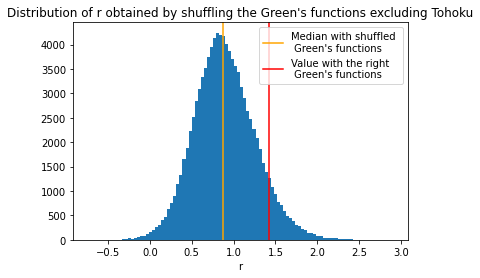

In [19]:
# Plot histogram of r with shuffled Green's functions excluding Tohoku

plt.hist(r_noTO,100)
plt.axvline(x=np.median(r_noTO),c='orange')
plt.axvline(x=r0_noTO,c='red')
plt.xlabel('r')
plt.title('Distribution of r obtained by shuffling the Green\'s functions excluding Tohoku')
plt.legend(['Median with shuffled \n Green\'s functions','Value with the right \n Green\'s functions'])
plt.savefig('r_GF_shuffled.pdf')
print('The median of r with shuffled Green\'s functions excluding Tohoku is '+str(round(np.median(r_noTO),2)))

In [20]:
p_noTO = 100*len(np.where(r_noTO>=r0_noTO)[0])/len(r)
print('r > '+str(round(r0_noTO,2))+' has a probability of '+str(round(p_noTO,1))+' %')

r > 1.42 has a probability of 8.2 %


Excluding Tohoku does not affect significantly the results.

# Conclusion

We find that the statistics on r obtained by shuffling the Green's functions is fairly high, which indicates the likely influence of common modes in the signal we observe. This is particularly true for the Tohoku stack, as removing it significantly lower the median r ratio (from 1.23 to 0.88). Nevertheless, obtaining an r as high by randomly shuffling the Green's function is unlikely (6.5 % in the general case, 8 % excluding Tohoku). This suggests that a common mode alone is insufficient to explain the statistical significance of r.